## Mental Health in the Tech Industry EDA

In this project [Mental Health in the Tech Industry](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry/data?select=mental_health.sqlite) dataset is analyzed.

### Objectives

- Practice performing EDA using Pandas.
- Practice visualizing data with Matplotlib & Seaborn.
- Practice estimating population parameters from sample data and communicating uncertainty around your insights.

*As this data set has more than 100 different questions, only part of questions were selected to be used in analysis.*

Analysis will be done to answer these main groups of questions using below listed questions from survey:
1. Overview of respondends. Sociodemographic features and sampling bias.
    - 1	What is your age?
    - 2	What is your gender?
    - 3	What country do you live in?
    - 50 What country do you work in?
    - 89 What is your race?
    - 5	Are you self-employed?
    - 8	How many employees does your company or organization have?
    - 9	Is your employer primarily a tech company/organization?
    - 13 Is your primary role within your company related to tech/IT?

2. Exploratory analysis
- How employee evaluates their mental health?
    - 6	Do you have a family history of mental illness?
    - 7	Have you ever sought treatment for a mental health disorder from a mental health professional?
    - 32 Have you had a mental health disorder in the past?
    - 33 Do you currently have a mental health disorder?
    - 34 Have you ever been diagnosed with a mental health disorder?
        
- How mental health is perceived comparing to physical health?
    - 10 Does your employer provide mental health benefits as part of healthcare coverage?
    - 64 Overall, how much importance does your employer place on physical health?
    - 65 Overall, how much importance does your employer place on mental health?
    - 90 Do you think that discussing a physical health issue with your employer would have negative consequences?
    - 98 Do you think that discussing a mental health issue with your employer would have negative consequences?
    - 91 Do you feel that your employer takes mental health as seriously as physical health?
        
- How potential mental health issues may affect work and carrier?
    - 48 If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?
    - 49 If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?
    - 54 Do you believe your productivity is ever affected by a mental health issue?
    - 55 If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?
    - 79 Has being identified as a person with a mental health issue affected your career?
    - 80 How has it affected your career?
    - 85 Overall, how well do you think the tech industry supports employees with mental health issues?
        
3. Prevalance rate of 3 mental diseases
    - 115 If yes, what condition(s) have you been diagnosed with?
    

### 1. Data preparation

In [784]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import plotly.express as px
from scipy.stats import chi2_contingency
import itertools
from plotly.subplots import make_subplots

Data is read from the source via SQL query with selected questions.

In [785]:
db_path = "mental_health.sqlite"
conn = sqlite3.connect(db_path)

query = """
WITH qtu AS (
    SELECT 
        q.questionid questionid,
        q.questiontext questiontext
    FROM Question q
    WHERE questionid IN (1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 32, 33, 34, 48, 49, 50, 54, 55, 64, 65, 79, 80, 85, 89, 90, 91, 98, 115)
    )
SELECT 
    a.SurveyID, 
    a.UserID, 
    qtu.questionid, 
    qtu.questiontext, 
    a.AnswerText
FROM 
    Answer a
JOIN 
    qtu 
ON 
    a.QuestionID = qtu.questionid
"""

df = pd.read_sql_query(query, conn)
conn.close()

Data is transformed to more convenient form for analysys, where each row represent one observation, and each column - one measurement / question. 

In case same user provides multiple answers to the same question, all of them are joined to the one answer.

In [786]:
pivot_df = df.pivot_table(
    index=["SurveyID", "UserID"],
    columns="questionid",
    values="AnswerText",
    aggfunc=lambda x: ", ".join(x),
)

pivot_df.reset_index(inplace=True)
pivot_df.columns = pivot_df.columns.astype(str).str.strip()
pivot_df.head(10)

questionid,SurveyID,UserID,1,2,3,5,6,7,8,9,...,64,65,79,80,85,89,90,91,98,115
0,2014,1,37,Female,United States,-1,No,1,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,No,NaN
1,2014,2,44,Male,United States,-1,No,0,More than 1000,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Don't know,Maybe,NaN
2,2014,3,32,Male,Canada,-1,No,0,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,NaN
3,2014,4,31,Male,United Kingdom,-1,Yes,1,26-100,1,...,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No,Yes,NaN
4,2014,5,31,Male,United States,-1,No,0,100-500,1,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Don't know,No,NaN
5,2014,6,33,Male,United States,-1,Yes,0,6-25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Don't know,No,NaN
6,2014,7,35,Female,United States,-1,Yes,1,1-5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,Maybe,Don't know,Maybe,NaN
7,2014,8,39,Male,Canada,-1,No,0,1-5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,No,NaN
8,2014,9,42,Female,United States,-1,Yes,1,100-500,1,...,NaN,NaN,NaN,NaN,NaN,NaN,No,No,Maybe,NaN
9,2014,10,23,Male,Canada,-1,No,0,26-100,1,...,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes,No,NaN


### 2. Data cleanup

Some column names will be changed for easier data analysis. Other will be left as question number, but will be introduced in details during analysis steps.

In [787]:
pivot_df.rename(
    columns={
        "SurveyID": "Year",
        "1": "Age",
        "2": "Gender",
        "3": "Live_country",
        "50": "Work_country",
        "89": "Race",
        "5": "Self_employed",
        "8": "Company_size",
        "9": "Is_tech_company",
        "13": "Primary_role_tech",
    },
    inplace=True,
)

**SurveyID** and **UserID** are int64 type, all others - object type.

**Age** will be converted to integer. All others - to categorical data. 

Categories names will be changed to be more understandable.

In [788]:
pivot_df = pivot_df.astype("category")

pivot_df["Company_size"] = pivot_df["Company_size"].apply(
    lambda x: "NoAnswer" if x == "-1" else ">1000" if x == "More than 1000" else x
)
company_size_order = [
    "NoAnswer",
    "1-5",
    "6-25",
    "26-100",
    "100-500",
    "500-1000",
    ">1000",
]
pivot_df["Company_size"] = pd.Categorical(
    pivot_df["Company_size"], categories=company_size_order, ordered=True
)

pivot_df["Year"] = pd.to_numeric(pivot_df["Year"], errors="coerce").astype("int")
pivot_df["UserID"] = pd.to_numeric(pivot_df["UserID"], errors="coerce").astype("int")
pivot_df["Age"] = pd.to_numeric(pivot_df["Age"], errors="coerce").astype("int")

pivot_df["Self_employed"] = pivot_df["Self_employed"].apply(
    lambda x: "Yes" if x == "1" else "No" if x == "0" else "No Answer"
)
pivot_df["Is_tech_company"] = pivot_df["Is_tech_company"].apply(
    lambda x: "Yes" if x == "1" else "No" if x == "0" else "No Answer"
)
pivot_df["Primary_role_tech"] = pivot_df["Primary_role_tech"].apply(
    lambda x: "Yes" if x == "1" else "No" if x == "0" else "No Answer"
)
pivot_df["79"] = pivot_df["79"].apply(
    lambda x: "Yes" if x == "1" else "No" if x == "0" else "No Answer"
)
pivot_df["7"] = pivot_df["7"].apply(lambda x: "Yes" if x == "1" else "No")
pivot_df["32"] = pivot_df["32"].apply(
    lambda x: (
        "Don't Know" if x in ["Possibly", "Maybe"] else "No Answer" if x == "-1" else x
    )
)
pivot_df["33"] = pivot_df["33"].apply(
    lambda x: "Don't Know" if x in ["Possibly", "Maybe"] else x
)
pivot_df["34"] = pivot_df["34"].apply(lambda x: "No Answer" if x == "-1" else x)


yes_no_order = ["Yes", "No", "No Answer"]
pivot_df["Self_employed"] = pd.Categorical(
    pivot_df["Self_employed"], categories=yes_no_order, ordered=True
)
pivot_df["Is_tech_company"] = pd.Categorical(
    pivot_df["Is_tech_company"], categories=yes_no_order, ordered=True
)
pivot_df["Primary_role_tech"] = pd.Categorical(
    pivot_df["Primary_role_tech"], categories=yes_no_order, ordered=True
)
pivot_df["79"] = pd.Categorical(pivot_df["79"], categories=yes_no_order, ordered=True)

Data cleanup will be done for each of the feature, including:
- checking for outliers, 
- grouping data for easier analysis,
- checking of Na values

In [789]:
print(pivot_df[["Age", "Year"]].groupby("Year").describe())

questionid     Age                                                      
             count       mean        std   min    25%   50%   75%    max
Year                                                                    
2014        1260.0  32.134921  11.392592 -29.0  27.00  31.0  36.0  329.0
2016        1433.0  34.286113  11.290931   3.0  28.00  33.0  39.0  323.0
2017         756.0  34.892857   8.529988  -1.0  29.00  34.0  40.0   67.0
2018         417.0  34.916067   8.047047  19.0  29.00  34.0  39.0   67.0
2019         352.0  35.494318   9.079577   0.0  28.75  34.0  41.0   64.0


There are some outliers / wrongly recorded data: age more than 300 years, or negative years. 
In order not to remove it from data set, these values will be change to Na.

In [790]:
pivot_df["Age"] = pivot_df["Age"].apply(lambda x: x if 14 <= x <= 90 else np.nan)

**Gender** feature contain multiple values, which will be grouped into: "Female", "Male", "Other".

In [791]:
pivot_df["Gender"] = (
    pivot_df["Gender"]
    .str.capitalize()
    .apply(lambda x: x if x in ["Female", "Male"] else "Other")
)

Number of Na values are checked for each feature.

In [792]:
print(
    "Number of Na values for each feature:\n",
    pivot_df.isna().sum(),
    end="\n\n",
)

pivot_df.groupby("Year").count().transpose()

Number of Na values for each feature:
 questionid
Year                    0
UserID                  0
Age                    14
Gender                  0
Live_country            0
Self_employed           0
6                       0
7                       0
Company_size            0
Is_tech_company         0
10                      0
Primary_role_tech    1260
32                   1260
33                   1260
34                   1260
48                   1260
49                   1260
Work_country         1260
54                   1260
55                   1260
64                   2693
65                   2693
79                   2693
80                   2693
85                   2693
Race                 2693
90                   1525
91                   1525
98                   2958
115                  2785
dtype: int64



Year,2014,2016,2017,2018,2019
questionid,,,,,
UserID,1260,1433,756,417,352
Age,1252,1430,754,417,351
Gender,1260,1433,756,417,352
Live_country,1260,1433,756,417,352
Self_employed,1260,1433,756,417,352
6,1260,1433,756,417,352
7,1260,1433,756,417,352
Company_size,1260,1433,756,417,352
Is_tech_company,1260,1433,756,417,352


- **Age** has 14 which are result of treating outliers.
- Other features have more Na. This indicates that questions were not the same during each year surveys.

#### Summary of Survey

- It was not perfomed yearly. Data from 2015 is not available.
- Number of respondens have decreasing tendency from ~1400 to ~350. Not sufficient sample size can have impact on results.
- Not the same questions were used every year, which makes analysis more complicated.
- There is no information about how representative is sample in regards to **Age**, **Gender**, **Race** and other features.
- Data collectione method - online questionair in OSMI page implies that respondents are the ones who are interested / related to Mental Health. This results in overestimation of MH.

### 3. Overview of the respondents sociodemographic features

Folowing questions were used as basis to have overview of respondents
- 1	What is your age?
- 2	What is your gender?
- 3	What country do you live in?
- 50 What country do you work in?
- 89 What is your race?
- 5	Are you self-employed?
- 8	How many employees does your company or organization have?
- 9	Is your employer primarily a tech company/organization?
- 13 Is your primary role within your company related to tech/IT?
- 117 Which of the following best describes your work position?

#### 3.1. Respondents overview by **Age**:

**Age** is continuos variable, and for analysis it is better to have it grouped.

In [793]:
print(pivot_df[["Age", "Year"]].groupby("Year").describe())

age_bins = [0, 23, 28, 33, 38, 43, 48, 100]
age_labels = ["<24", "24-28", "29-33", "34-38", "39-43", "44-48", "48+"]

pivot_df["Age_category"] = pd.cut(pivot_df["Age"], bins=age_bins, labels=age_labels)

pivot_df["Age_category"] = pd.Categorical(
    pivot_df["Age_category"], categories=age_labels, ordered=True
)

fig1 = px.histogram(
    pivot_df,
    x="Age_category",
    facet_col="Year",
    category_orders={"Age_category": age_labels},
    height=350,
    title="Respondents distribution by Age groups",
)

fig2 = px.histogram(
    pivot_df,
    x="Age_category",
    facet_col="Year",
    category_orders={"Age_category": age_labels},
    histnorm="percent",
    height=300,
)

fig1.show()
fig2.show()

questionid     Age                                                    
             count       mean       std   min   25%   50%    75%   max
Year                                                                  
2014        1252.0  32.083866  7.289722  18.0  27.0  31.0  36.00  72.0
2016        1430.0  34.060839  8.108938  15.0  28.0  33.0  38.75  74.0
2017         754.0  34.988064  8.338051  18.0  29.0  34.0  40.00  67.0
2018         417.0  34.916067  8.047047  19.0  29.0  34.0  39.00  67.0
2019         351.0  35.595442  8.891819  19.0  29.0  34.0  41.00  64.0


- Basic descriptive statistics show average respondet **Age** at ~34-35 years, with only in 2014 being at 32 years.
- Distribution in age groups is similar in first 3 Surveys, however in the last years there is tendency of lower level of participation of younger respondents.

#### 3.2. Respondents overview by **Gender**:

In [794]:
fig1 = px.histogram(
    pivot_df,
    x="Gender",
    facet_col="Year",
    height=350,
    title="Respondens distribution by Gender",
)

fig1.show()

- Most of respondents **Gender** is Male with about 4-1, 3-1 ratio compared to **Female**. 
- Over the years, as total number of respondens decreases, gap becomes smaller with about 2-1 ratio.

#### 3.3. Respondents overview by **Race**:

In [795]:
pivot_df["Race"] = pivot_df["Race"].replace(
    {"Caucasian": "White", "I prefer not to answer": "No Answer", "-1": "No Answer"}
)

fig1 = px.histogram(
    pivot_df[pivot_df["Year"] > 2016],
    x="Race",
    facet_col="Year",
    title="Respondents distribution by Race",
)
fig2 = px.histogram(
    pivot_df[(pivot_df["Year"] > 2016) & (pivot_df["Race"] != "No Answer")],
    x="Race",
    facet_col="Year",
    title="Respondents distribution by Race, 'No Answer' excluded",
    histnorm="percent",
)

fig1.show()
fig2.show()

C:\Users\milda\AppData\Local\Temp\ipykernel_11144\265752713.py:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



- Around 57% of respondents are **White**
- Around 37% of respondens didn't answer to this question. This could be one of the topics for further analysis, to see how **Race** is related to answers to other questions.
- From the ones who answered - majority is **White**.

#### 3.4. Respondents overview by **Live_country** and **Work_country**:

It will be checked if respondents tend to **Live** and **Work** in the same country.

In [796]:
pivot_df["Live_country"] = pivot_df["Live_country"].replace(
    {"United States": "United States of America"}
)

pivot_df["Live_Work_same_country"] = pivot_df.apply(
    lambda row: True if row["Live_country"] == row["Work_country"] else False, axis=1
)

fig = px.histogram(pivot_df, x="Live_Work_same_country", facet_col="Year", height=300)
fig.show()

C:\Users\milda\AppData\Local\Temp\ipykernel_11144\783067135.py:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [797]:
print(
    pivot_df[pivot_df["Year"] > 2014]["Live_country"].value_counts().head(),
    end="\n\n",
)
print(pivot_df[pivot_df["Year"] > 2014]["Work_country"].value_counts().head())

Live_country
United States of America    1853
United Kingdom               297
Canada                       127
Germany                       91
Netherlands                   71
Name: count, dtype: int64

Work_country
United States of America    1872
United Kingdom               300
Canada                       122
Germany                       90
Netherlands                   70
Name: count, dtype: int64


In [798]:
print(
    pivot_df[(pivot_df["Year"] > 2014) & (pivot_df["Live_Work_same_country"] == 0)][
        ["Live_country", "Work_country"]
    ].head()
)

questionid              Live_country              Work_country
1510        United States of America      United Arab Emirates
1565                           Spain  United States of America
1568                          Canada  United States of America
1594                  United Kingdom  United States of America
1646        United States of America                    Turkey


- **Work_country** data was not collected in year 2014. There for, this year was excluded from this analysis part.
- For years where both **Live_country** and **Work_country** data is avalable majority of respondens stated that they live and work in the same country.
- There are 50 respondents stating that they live and work in different countries.
- Most respondents stated that they Live and/or Work in United States of America, with United Kingdom and Canada going next. This suggests that online survey is more known / more used by North America employees.

#### 3.5. Company overview:

It will be checked what type of companies respondends work in considering:
- Self employment
- Company size
- Is company primaraly a tech company

In [799]:
fig = px.histogram(
    pivot_df,
    x="Company_size",
    facet_col="Year",
    height=350,
    category_orders={"Company_size": company_size_order, "Self_employed": yes_no_order},
    color="Self_employed",
    title="Respondens distribution by Company size and Self employment",
)

fig.show()

- Majority of respondents are not self employed. 
- In 2016 and folowing surveys, **Self employed** respondends were not answering question regarding **Company size**.
- Self employed respondents tend to work in smaller companies.

In [800]:
fig = px.histogram(
    pivot_df[pivot_df["Is_tech_company"] != "-1"],
    x="Company_size",
    height=350,
    category_orders={
        "Company_size": company_size_order,
        "Is_tech_company": yes_no_order,
    },
    color="Is_tech_company",
    title="Respondens distribution by Company size and company field (Is / Is not tech company)",
)

fig.show()

- Survey respondents are working mainly in tech companies.
- Company size grouping is not equal / consistent, there for - biased, as it gives impression of higher frequency of specific company size, which is impacted by bigger range of that group.

In the original data set, **Primary role as related to tech** data is not available for 2014, so this year will also be excluded from next step.

In [801]:
fig = px.parallel_categories(
    pivot_df[(pivot_df["Self_employed"] == "No") & (pivot_df["Year"] != 2014)][
        [
            "Self_employed",
            "Company_size",
            "Is_tech_company",
            "Primary_role_tech",
        ]
    ]
)

fig.show()

- Nearly 25% of respondends working in not tech company has primary role related to tech. 
- More than 10% respondens work in the biggest, non tech companies, with role related to tech, which implies that usually bigger companies tend to have resources dedicated to specific field / topics, in this case - tech.

#### Summary for sociodemographic features

Tipical respondent from this data set is white male, living in North America, working in relatively big Tech company, and primary role related to tech.

**1. It will be compared how it coresponds to all population:**
- Gender: Male (50.4%), Female (49.6%)
- Age groups: 0-14 (24.5%), 15-64 (65.2%), >65 (10.3%). Median - 31
- Race: Asian (54%), Black (15%), White (15%), Hispanic (8%), Middle Eastern (8%)

*It is clear that Age distribution from data set is similar to population. However Gender and Race proportions are not close to population.*


2. As most frequently mentioned country for work and / or live was United States of America, nes step will be to check **How it coresponds to United States of America population:**
- Gender: Male (49.5%), Female (50.5%)
- Race: White (60.1%), Hispanic (18.5%), Black (12.2%), Asian (5.6%), Multiple Races (2.8%), American Indian (0.7%), Native Havaian (0.2%) as of year 2019.

*Data set has big proportion (37%) respondents who didn't answer question about Race. From the ones who answered ~90 is **White**.*

3. Next step - to see **How this corresponds to American Tech companies** [Data sourse](https://www.forbes.com/advisor/education/it-and-tech/tech-industry-statistics-and-facts/#:~:text=While%20white%20employees%20make%20up,hold%2014%25%20of%20tech%20jobs.)
- Gender: Male-Female ratio is about in different sources is from 4:1 to 2:1.
- Age groups: Average is ~38
- Race: White (68.5%), Asian American (14%), African American (7.4%), Hispanic (8.0%).


*Gender ratio from data set is close to American tech company. Respondens average age is slightly lower. Respondents race distribution is closer to American Tech companies, however not enough. Error here may be because of high proportion "No Answers" in data set.*

**Summary**
- Because of sampling bias, this data is not representative to provide generealised insights about Mental healf (MH) of population.
- Before making inference about MH of employees in tech companies, sociodemographic information (using weighting) should be adjusted. 
- Information about distribution of MH in tech companies has to be collected to have correct conclusions.

### 4. Data analysis

#### 4.1. How employee mental health changes over time? Can current condition be predicted by family history or medical history?

Folowing questions will be used to answer this question
- 6	Do you have a family history of mental illness?
- 7	Have you ever sought treatment for a mental health disorder from a mental health professional?
- 32 Have you had a mental health disorder in the past?
- 33 Do you currently have a mental health disorder?
- 34 Have you ever been diagnosed with a mental health disorder?

In [824]:
fig = px.parallel_categories(
    pivot_df[pivot_df["Year"] != 2014][["6", "32", "33", "34", "7"]],
    height=400,
    labels={
        "6": "MH in Family history",
        "7": "Have you sought treatment?",
        "32": "MH in the past",
        "33": "MH currently",
        "34": "MH diagnosed",
    },
)
fig.show()

- About 20 % of respondents answered "Yes" to all questions.
- ~50 % respondents who said there is Family history of MH answered "Yes" to all further questions. About 7 % answered "No" to all questions. And another 7 % "No" to all except "MH diagnozed" which was not answered. This implies that Family history of MH could be used for predicting other features.
- Nearly 30 % of respondents prefer not to answer the question about MH dieagnosis. The reason behind this could be: 
    - acceptance fear, 
    - uncertainty about anonimity of survey,
    - fear to acknowledge results (most likely positive), there for not - answering.

**Chi-squared statistics** and **p-value** will be calculated for each pair to check is there a relationship between them.

In [803]:
variables = ["6", "7", "32", "33", "34"]
chi2_matrix = pd.DataFrame(index=variables, columns=variables)
p_value_matrix = pd.DataFrame(index=variables, columns=variables)


def calculate_chi_square(df, var1, var2):
    contingency_table = pd.crosstab(df[var1], df[var2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p


for var1, var2 in itertools.combinations(variables, 2):
    chi2_stat, p_value = calculate_chi_square(pivot_df, var1, var2)

    chi2_matrix.loc[var1, var2] = chi2_stat
    p_value_matrix.loc[var1, var2] = p_value

chi2_matrix.fillna("", inplace=True)
p_value_matrix.fillna("", inplace=True)

print("Chi-Squared Matrix:")
print(chi2_matrix)

print("\nP-Value Matrix:")
print(p_value_matrix)

Chi-Squared Matrix:
   6           7           32           33           34
6     673.459162   628.012262   560.046326   421.684712
7                 1433.256981   1064.08443  1337.228482
32                             1822.967163  1513.250897
33                                          2041.862123
34                                                     

P-Value Matrix:
   6    7   32   33   34
6     0.0  0.0  0.0  0.0
7          0.0  0.0  0.0
32              0.0  0.0
33                   0.0
34                      


High **Chi-squared** value and **p-value** lower than 0.05 suggest that there is strong association between those categorical variables.

##### Summary

Family history of MH can be good indicator predicting MH disorders.

#### 4.2. How mental health is perceived comparing to physical health?

Folowing questions will be used to answer this question
- 10 Does your employer provide mental health benefits as part of healthcare coverage?
- 64 Overall, how much importance does your employer place on physical health?
- 65 Overall, how much importance does your employer place on mental health?
- 90 Do you think that discussing a physical health issue with your employer would have negative consequences?
- 98 Do you think that discussing a mental health issue with your employer would have negative consequences?
- 91 Do you feel that your employer takes mental health as seriously as physical health?

Firstly, comparison will be done, to see if mental and physical health are treated with same importance.

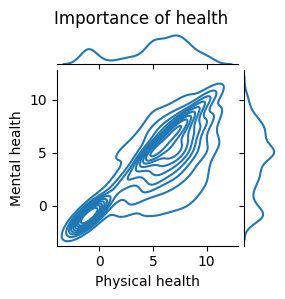

In [804]:
pivot_df["64"] = pd.to_numeric(pivot_df["64"], errors="coerce")
pivot_df["65"] = pd.to_numeric(pivot_df["65"], errors="coerce")

g = sns.jointplot(pivot_df, x="64", y="65", kind="kde", height=3)
g.ax_joint.set_xlabel("Physical health")
g.ax_joint.set_ylabel("Mental health")
g.fig.suptitle("Importance of health")
g.fig.subplots_adjust(top=0.9)

plt.show()

- This shows possible linear relationship between importance of physical and mental health.
- Apart from not answering these questions at all (value = -1), most respondents stated importance around 5-7. 

Further will be checked if there is difference in these values in regards to **Gender** and **Year**.

In [805]:
fig = px.density_contour(
    pivot_df[pivot_df["Year"] > 2016],
    x="64",
    y="65",
    facet_col="Year",
    facet_row="Gender",
    width=500,
    labels={"64": "Physical", "65": "Mental"},
    title="Importance of health by Gender and Year",
)
fig.show()

Correlation will be calculated to evaluate how strong is the relationship.

In [806]:
pivot_df[["64", "65"]].corr()

questionid,64,65
questionid,,
64,1.000000,0.782514
65,0.782514,1.000000


- There are no major differences while diferenciating by **Gender** and **Year**.
- Correlation coeficient show strong relationship between how importance on mental and physical health is perceived.  

Next step is to check how comfortable respondens are discussing their mental and physical health with employers.

In [807]:
fig = px.density_contour(
    pivot_df[pivot_df["90"] != "-1"],
    x="90",
    y="98",
    width=700,
    category_orders={"90": ["No", "Maybe", "Yes"], "98": ["Yes", "Maybe", "No"]},
    labels={"90": "Physical health", "98": "Mental health"},
    title="Do you think there will be negative consequences discussing..? Year: 2014",
)
fig.update_traces(contours_coloring="fill")
fig.show()

In [823]:
fig = px.density_contour(
    pivot_df[(pivot_df["Year"] == 2014) & pivot_df["Age_category"].notna()],
    x="90",
    y="98",
    height=300,
    facet_col="Age_category",
    labels={"90": "Physical health", "98": "Mental health"},
    title="Do you think there will be negative consequences discussing..? Year: 2014",
    category_orders={"Age_category": age_labels},
)

fig.show()

- Majority of respondents do not see negative consequences discussing mental and physical health.
- However tendency is that respondents think there will more be negative consequences discussing mental health compared to physical health.
- Tendencies to see negative consequences increase with **Age**.

Next step is to check if company's policy providing Mental health benefits has relation to how respondents feel Mental health is treated comparing to Physical health.

In [809]:
pivot_df["10"] = pivot_df["10"].replace(
    {
        "I don't know": "Don't know",
        "Not eligible for coverage / NA": "Not eligible",
        "-1": "No Answer",
    }
)
pivot_df["91"] = pivot_df["91"].replace(
    {"I don't know": "Don't know", "-1": "No Answer"}
)


fig = px.density_contour(
    pivot_df[(pivot_df["Year"] <= 2016)],
    x="10",
    y="91",
    width=600,
    category_orders={
        "10": ["Yes", "Don't know", "No", "Not eligible", "No Answer"],
        "91": ["No Answer", "No", "Don't know", "Yes"],
    },
    labels={
        "10": "Does your employer provide MH benefits as part of healthcare coverage?",
        "91": "MH as seriously as PH?",
    },
    title="MH benefits relation to MH importance. Year: 2014, 2016",
)

fig.update_traces(contours_coloring="fill")
fig.show()

C:\Users\milda\AppData\Local\Temp\ipykernel_11144\2110793923.py:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

C:\Users\milda\AppData\Local\Temp\ipykernel_11144\2110793923.py:8: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [810]:
fig = px.density_contour(
    pivot_df[(pivot_df["Year"] <= 2016)],
    x="10",
    y="91",
    height=400,
    facet_col="Self_employed",
    category_orders={
        "10": ["Yes", "Don't know", "No", "Not eligible", "No Answer"],
        "91": ["No Answer", "No", "Don't know", "Yes"],
    },
    labels={
        "10": "MH benefits as part of healthcare coverage?",
        "91": "MH as seriously as PH?",
    },
    title="MH benefits relation to MH importance. Year: 2014, 2016",
)

fig.show()

- Respondents who didn't answer to these questions are self-employed.
- From respondents who answered seems like better communication or actions inside company would be needed. Even though company is providing Mental health benefit as part of healthcare coverage, it seems like respondends do not know if Mental and Physical health is treated the same.

##### Summary

- There is strong liner relationship (correlation coeficient = 0.78) between importance of MH and PH, which suggests that both MH and PH are perceived similarly.
- Majority of respondents think there will be "No" negative consequencies discussing MH and / or PH. However there is tendency that respondens tend to feel more secured discussing PH. Uncertainty about PH increases in older Age groups.
- Providing MH benefit as part of healthcare coverage doesn't guarantee that employees will notice and / or appreciate this. Additional actions might be needed, like:
    - better internal communication,
    - ensuring safe and trust in enviroment,
    - letting employees see not only by words, but also by actions that MH is treated as seriously as PH.

#### 4.3. How potential mental health issues may affect work and carreer?

Folowing questions will be used to answer this question
- 48 If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?
- 49 If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?
- 54 Do you believe your productivity is ever affected by a mental health issue?
- 55 If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?
- 79 Has being identified as a person with a mental health issue affected your career?
- 80 How has it affected your career?
- 85 Overall, how well do you think the tech industry supports employees with mental health issues?

For this part analysis will be done on data where respondents answered that they have currently Mental health disorder (questionID 33 = Yes).

In [811]:
fig1 = px.histogram(
    pivot_df[pivot_df["33"] == "Yes"],
    x="48",
    facet_col="Year",
    height=300,
    width=1000,
    category_orders={
        "48": ["Often", "Sometimes", "Rarely", "Never", "Not applicable to me"]
    },
    labels={"48": " "},
    title="How often do you feel that MH disorder interferes with your work when being treated effectively?",
)
fig2 = px.histogram(
    pivot_df[pivot_df["33"] == "Yes"],
    x="49",
    facet_col="Year",
    height=300,
    width=1000,
    category_orders={
        "49": ["Often", "Sometimes", "Rarely", "Never", "Not applicable to me"]
    },
    labels={"49": " "},
    title="How often do you feel that MH disorder interferes with your work when NOT being treated effectively?",
)

fig1.show()
fig2.show()

- Answers show importance of treating MH disorders effectively, as this may lead to less impact on work.

Next will be checked How productivity is impacted by MH disorder.

In [812]:
pivot_df["54"] = pivot_df["54"].replace({"-1": "No Answer"})
pivot_df["55"] = pivot_df["55"].replace({"-1": "No Answer"})

fig1 = px.density_contour(
    pivot_df[(pivot_df["33"] == "Yes") & (pivot_df["Year"] > 2014)],
    x="54",
    y="55",
)


fig2 = px.density_contour(
    pivot_df[
        (pivot_df["33"] == "Yes")
        & (pivot_df["Year"] > 2014)
        & (pivot_df["54"] != "No Answer")
        & (pivot_df["55"] != "No Answer")
    ],
    x="54",
    y="55",

)

fig = make_subplots(rows=1, cols=2)
for trace in fig1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in fig2.data:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(
    title_text="MH effect on productivity. Year: 2016-2019", height=400, width=1000
)

fig.update_xaxes(
    title_text="Is productivity ever affected by a MH issue?",
    categoryorder="array",
    categoryarray=[
        "No Answer",
        "Yes",
        "Unsure",
        "No",
        "Not applicable to me",
    ],
)

fig.update_yaxes(
    title_text="What % of your work time is affected by a MH issue?",
    categoryorder="array",
    categoryarray=["No Answer", "1-25%", "26-50%", "51-75%", "76-100%"],
    row=1,
    col=1,
)
fig.update_yaxes(
    categoryorder="array",
    categoryarray=["No Answer", "1-25%", "26-50%", "51-75%", "76-100%"],
    row=1,
    col=2,
)


fig.show()

C:\Users\milda\AppData\Local\Temp\ipykernel_11144\4181055556.py:1: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.

C:\Users\milda\AppData\Local\Temp\ipykernel_11144\4181055556.py:2: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



- When asked if productivity is affected by MH disorder, majority of respondents choose not to answer this question. This may signal lack of trust in work enviroment. 
- The ones who answered - stated that productivity is affected by MH disorder. 

MH impact for career

In [813]:
fig1 = px.histogram(
    pivot_df[(pivot_df["33"] == "Yes") & (pivot_df["Year"] > 2016)],
    x="79",
    facet_col="Year",
    height=300,
    category_orders={"79": yes_no_order},
    labels={"79": ""},
    title="Has being identified as a person with a mental health issue affected your career?",
)
fig2 = px.histogram(
    pivot_df[
        (pivot_df["33"] == "Yes")
        & (pivot_df["Year"] > 2016)
        & (pivot_df["79"] == "Yes")
    ],
    x="80",
    facet_col="Year",
    height=300,
    category_orders={
        "80": ["-1", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
    },
    labels={"80": ""},
    title="How has it affected your career? (Only ones who answered 'Yes' to previous question)",
)

fig1.show()
fig2.show()

- When asked directly about MH impact to career, most respondents did not answer. However from the ones who answered it seems that impact was rather negative than positive.

Next will be check overall rating how Tech companies support employees wit MH disorders.

In [814]:
px.histogram(
    pivot_df,
    x="85",
    height=400,
    facet_col="Gender",
    labels={"85": ""},
    title="Overall, how well do you think the tech industry supports employees with MH issues?",
)

- Respondens see overall support for MH disorders from employers rather neutral - towards negative.

##### Summary

- MH treatment has impact on work and productivity.
- Respondens were resistant to admit (Did not answer question) that productivity may be impacted by MH. This may signal about fear, untrust in the working enviroment.
- Respondents were reluctant to answer if MH disorder affected their career. The ones who answers saw impact more negatively.
- Overall Tech company rating is neutral towards negative.

### 5. Prevalence rate for 3 mental health disorders

List of disorders is read from SQL sourse.

In [815]:
db_path = "mental_health.sqlite"
conn = sqlite3.connect(db_path)

query = """
WITH qtu AS (
    SELECT 
        q.questionid questionid
    FROM Question q
    WHERE questionid = 115
    )
SELECT DISTINCT 
    a.AnswerText AS Disorder, 
    COUNT(*) AS total_counts
FROM Answer a
JOIN qtu 
ON a.QuestionID = qtu.questionid
WHERE a.AnswerText != -1
GROUP BY 1
ORDER BY 2 DESC
"""

disorder = pd.read_sql_query(query, conn)
conn.close()

Check of most frequent disorders.

In [816]:
print(disorder.head())

                                            Disorder  total_counts
0  Mood Disorder (Depression, Bipolar Disorder, etc)           412
1  Anxiety Disorder (Generalized, Social, Phobia,...           345
2           Attention Deficit Hyperactivity Disorder           121
3                     Post-traumatic Stress Disorder            69
4                      Obsessive-Compulsive Disorder            45


Additional columns in data frame will be created to represent 3 most common disorders.

In [817]:
pivot_df["Mood_disorder"] = pivot_df["115"].apply(
    lambda x: 1 if "Mood Disorder" in str(x) else 0
)

pivot_df["Anxiety"] = pivot_df["115"].apply(
    lambda x: 1 if "Anxiety Disorder" in str(x) else 0
)

pivot_df["ADHD"] = pivot_df["115"].apply(
    lambda x: 1 if "Attention Deficit Hyperactivity Disorder" in str(x) else 0
)

New data frame will be created for calculation of prevalence and confidence intervals for 3 selected disorders: **Mood disorder**, **Anxiety** and **ADHD**.

The prevalence is calculated: $Pr = \frac{N}{T} * 100 \%$

Confidence intervals are calculated: $CI = Pr\pm error$, where $ error = z \times \sqrt{\frac{Pr (1 - Pr)}{T}}$

where Pr - prevalence rate, N - number of cases with disorder, T - number of total cases.

Diagnosed MH disorder in questionair was only in 2016. This makes it possible to see only Prevalence rate for that year.

In [818]:
MH_pr = (
    (
        pivot_df[["Gender", "Mood_disorder", "Anxiety", "ADHD"]].groupby("Gender").sum()
        / pivot_df[["Gender", "Mood_disorder", "Anxiety", "ADHD"]]
        .groupby("Gender")
        .count()
    )
    .round(4)
    .melt(ignore_index=False, var_name="Disorder", value_name="Pr")
    .reset_index()
)

MH_count = (
    pivot_df[["Gender", "Mood_disorder", "Anxiety", "ADHD"]]
    .groupby("Gender")
    .count()
    .melt(ignore_index=False, var_name="Disorder", value_name="Total")
    .reset_index()
)

MH = pd.merge(MH_pr, MH_count, on=["Gender", "Disorder"])

z = float(1.96)
MH["error"] = (z * np.sqrt((MH["Pr"] * (1 - MH["Pr"])) / MH["Total"])).round(4)
MH

,Gender,Disorder,Pr,Total,error
0,Female,Mood_disorder,0.4345,336,0.0530
1,Male,Mood_disorder,0.2289,1057,0.0253
2,Other,Mood_disorder,0.6000,40,0.1518
3,Female,Anxiety,0.3423,336,0.0507
4,Male,Anxiety,0.2015,1057,0.0242
5,Other,Anxiety,0.4250,40,0.1532
6,Female,ADHD,0.1190,336,0.0346
7,Male,ADHD,0.0719,1057,0.0156
8,Other,ADHD,0.1250,40,0.1025


Prevalence rate and Confidence intervals for selected Disorders will be plotted.

In [819]:
fig = px.bar(
    MH,
    x="Gender",
    y=MH["Pr"] * 100,
    error_y=MH["error"] * 100,
    labels={"y": "Prevalence (%)"},
    title="Prevalence rate of Disorders with 95% Confidence Intervals. Year: 2016",
    width=800,
    height=400,
    facet_col="Disorder",
)

fig.update_layout(
    yaxis_title="Prevalence (%)", xaxis_title="Gender", template="plotly_white"
)

fig.show()

#### Summary

***Prevalance rate** is the proportion of a particular population found to be affected by a medical condition / disease / or a risk factor at a specific time.*
- **Prevalence rate** for this data set is quite high. E.g. for Anxiety more than 34 % for Female, ~20 % for Male. In overall population ~ 300 mln out of 8000 mln have Anxiety. This makes ~ 3.75 % of population. Results here are impacted by data sourse - voluntary survey in OSMI web page. One of the reasons may be, that respondens who already have MH disorder were answering this survey more frequently. This makes data strongly biased.
- **Confidence intervals** is a range in which the actual prevalence will fall with the 95 % confidence.
- There is different **Prevalence rate** of having MH disorder depending on **Gender**. It would be interesting topic for further analysis to check Causation. 

### 6. What next analysis steps could be done

- Perform exploratory data analysis (EDA) with differentiation by **Gender**, **Race** and **Age_category**.
- Perfroms EDA with differentiation by **Currently have MH disorder** to see if this is related to how working enviroment is seen.